In [92]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import util
import os
import engutil


def loudspeaker_ode(t, x, u_func, params, polys):
    # unpack state vector
    i_curr = x[0]  
    i_creep = x[1] 
    disp   = x[2]    
    vel    = x[3]    
    
    voltage = u_func(t)
    
    # evaluate Bl and K_m polynomials
    P_Bl = polys['Bl'](disp)
    P_K  = polys['K'](disp)
    
    # displacement and current dependent parts of Le
    P_Le_d = polys['Le'](disp)  
    P_Li_i = polys['Li'](i_curr)
    val_Le = max(P_Le_d * P_Li_i, 1e-9)
    # partial derivs
    grad_Le_d = polys['Le'].deriv()(disp) 
    grad_Li_i = polys['Li'].deriv()(i_curr) # todo?
    
    # wrt displacement
    dLe_dd = grad_Le_d * P_Li_i
    
    # wrt current
    dLe_di = P_Le_d * grad_Li_i
    
    # Le*(d,i)
    Le_star = val_Le + i_curr * dLe_di
    
    # Le_nom # todo ? 
    Le_nom = polys['Le'](0) * polys['Li'](0)
    ratio = val_Le / Le_nom
    
    val_R2 = params['R20'] * ratio
    val_L2 = params['L20'] * ratio
    
    # L2 partial derivs
    # L2 is scaled version of Le, therefor it's derivatives scae by the same factor
    scale_factor = params['L20'] / Le_nom
    dL2_dd = scale_factor * dLe_dd
    dL2_di = scale_factor * dLe_di

    # constant values
    R_e = params['Re']
    R_m = params['Rm']
    M_m = params['Mm']
    K_m = P_K 
    Bl  = P_Bl 

   
    # eq 0
    di_dt = (voltage - i_curr * (R_e + val_R2) + val_R2 * i_creep - vel * (Bl + dLe_dd * i_curr)) / Le_star


    # eq 1
    # (-L_e_star*i_2*(R_2 + dL_2/dd*v) 
    # + dL_2/di*i_2*(-V_in + v*(Bl + dL_e/dd*i)) 
    # + i*(L_e_star*R_2 + R_e*dL_2/di*i_2))/
    # (L_2*L_e_star)

    term1 = -Le_star * i_creep * (val_R2 + dL2_dd * vel)
    term2 = dL2_di * i_creep * (-voltage + vel * (Bl + dLe_dd * i_curr))
    term3 = i_curr * (Le_star * val_R2 + R_e * dL2_di * i_creep)
    di2_dt = (term1 + term2 + term3) / (val_L2 * Le_star)

    # eq 2
    ddisp_dt = vel
    
    # eq 3
    # [x] (-K_m*d
    # [x] - R_m*v 
    # [x] + dL_2/dd*i_2**2/2 
    # + i*(2*Bl + dL_e/dd*i)/2) = i*2*Bl/2 + dLe_dd*i^2
    # /M_m
    force_electric = Bl * i_curr
    force_reluctance = 0.5 * dLe_dd * i_curr**2
    force_reluctance_2 = 0.5 * dL2_dd * i_creep**2 
    force_stiffness = -K_m * disp
    force_damping = -R_m * vel
    
    dvel_dt = (force_electric + force_reluctance + force_reluctance_2 + force_stiffness + force_damping) / M_m

    return [di_dt, di2_dt, ddisp_dt, dvel_dt]
    
# setup params
Bl = 6.837193705842441
R_e = 4.822146670305587
R_m = 2.2833222074164836
K_m = 1107.8705431240523
L_e0 = 0.000305207582223968 # samme som Ln(0)*Li(0)
M_m = 0.020004906958875274
L_20 = 0.0004325286577462285
R_20 = 2.504536634680621

Bln = [-2615563718.9455967, -3023090.98130258, -9835.616494456142, 21.171849188494026, Bl]
Kn  = [1724760519892.831, -5658865945.33859, 35715360.4027017, -210546.86882586573, K_m]
Ln  = [20081.188591764963, -319.17779393260366, 0.8155679039802962, -0.01018945289267653, L_e0]
Li  = [-0.0012237427320541485, -0.0014189369785025077, 0.007354393550658496, 0.005954177167801685, 1]

# polys = {
#     'Bl': np.poly1d(Bln),
#     'K':  np.poly1d(Kn),
#     'Le': np.poly1d(Ln),
#     'Li': np.poly1d(Li)
# }

params = {
    'Re': R_e, 'Rm': R_m, 'Mm': M_m, 'R20': R_20, 'L20': L_20, 'Le_nom': L_e0
}

# for calculating min fs
F_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m]
])

minimum_fs = util.calculate_min_fs(F_static)
print(f"Minimum Linear fs: {minimum_fs:.2f}")

# duration 2 and 3 * min fs tog ~4min
duration = 1
fs = 96e3 # int(5 * minimum_fs)
t_eval = np.linspace(0, duration, int(fs*duration))

#u = util.generate_pink_noise(len(t_eval), fs, fmin=1)
f_carrier = 40

u = 10*np.sqrt(2) * np.sin(2 * np.pi * f_carrier * t_eval)

# u(t) function - ie to be able to find values between sample values.. 
u_func = interp1d(t_eval, u, kind='linear', fill_value="extrapolate")


scenarios = [
    {
        "name": "01_nonlinear_full",
        "polys": {
            'Bl': np.poly1d(Bln),
            'K':  np.poly1d(Kn),
            'Le': np.poly1d(Ln),
            'Li': np.poly1d(Li)
        }
    },
    # {
    #     "name": "02_nonlinear_stiffness_only", # Example of a 3rd variation
    #     "polys": {
    #         'Bl': np.poly1d([Bl]), # Constant Bl
    #         'K':  np.poly1d(Kn),       # Non-linear Stiffness
    #         'Le': np.poly1d([L_e0]),   # Constant Le
    #         'Li': np.poly1d([1])
    #     }
    # },
    # {
    #     "name": "03_nonlinear_Bl_only",
    #     "polys": {
    #         'Bl': np.poly1d(Bln), #Nonlinear Bl
    #         'K':  np.poly1d([K_m]),       
    #         'Le': np.poly1d([L_e0]),  
    #         'Li': np.poly1d([1])
    #     }
    # },
    # {
    #     "name": "04_nonlinear_Le_only",
    #     "polys": {
    #         'Bl': np.poly1d([Bl]),
    #         'K':  np.poly1d([K_m]),       
    #         'Le': np.poly1d(Ln), # non linear bl  
    #         'Li': np.poly1d(Li)
    #     }
    # },

]

output_dir = "data/part2ddd_presentation"
os.makedirs(output_dir, exist_ok=True)

x0 = [0, 0, 0, 0] # initial conditions

for case in scenarios:
    print(f"Running simulation: {case['name']} ...")
    
    current_polys = case['polys']
    
    sol = solve_ivp(
        fun=loudspeaker_ode,
        t_span=(0, duration),
        y0=x0,
        t_eval=t_eval,      
        args=(u_func, params, current_polys), 
        method='RK45',      
        rtol=1e-3,       # 1e-3   (was 5)
        atol=1e-6        # 1e-6 ( was 8)
    )

    # Structure: [Time, voltage, Current, Creep_Current, Displacement, Velocity]
    data_to_save = np.vstack((sol.t, u, sol.y)).T
    
    filename = f"{output_dir}/{case['name']}_{duration}sec_at_{fs}.csv"
    
    # Save with header
    np.savetxt(
        filename, 
        data_to_save, 
        delimiter=",", 
        #header = f"fs={fs},duration={duration}\ntime,u,i,i_creep,disp,vel",
        header="time,u,i,i_creep,disp,vel",
        comments=""
    )
    
    print(f"Saved: {filename}")

print("All simulations complete.")

# excite model b og c med pink noise for at lave transfer functions (alle non linearities)
# plot dem
# 
# b og c med et par nonlinearities og sammenlign oven i hinanden
# alt samme
#  

#




Minimum Linear fs: 13027.62
Running simulation: 01_nonlinear_full ...
Saved: data/part2ddd_presentation/01_nonlinear_full_1sec_at_96000.0.csv
All simulations complete.


/home/istlf/SYNC/DTU/JAN26/non-linear-transducers-project/util.py:411: RuntimeWarning: divide by zero encountered in log10
  p_rms_dB = 20*np.log10(p_rms/(20e-6))


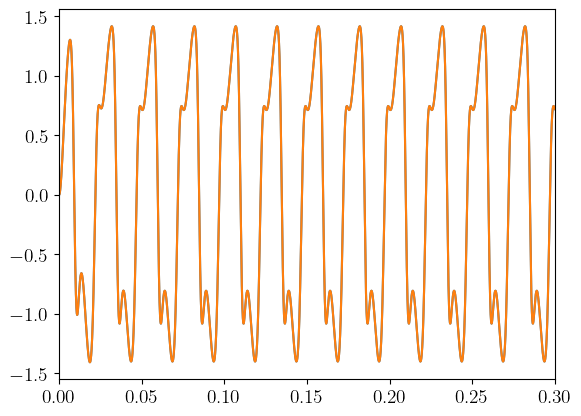

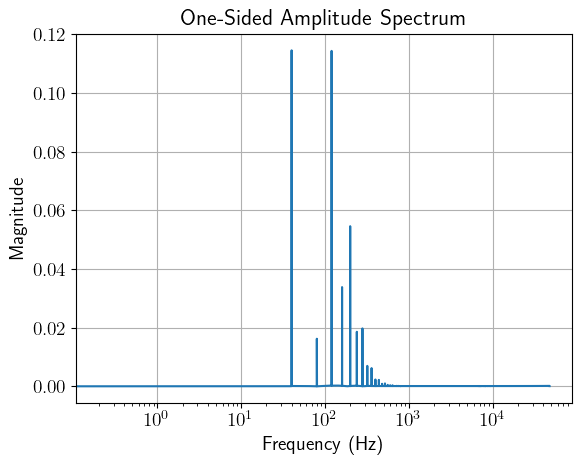

val_thd 0.7628456209849624


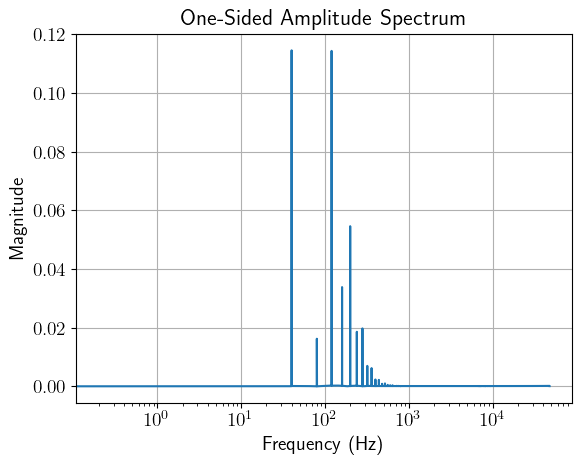

val_thd 0.7628456209849626


In [88]:
d= pd.read_csv("data/part2d_simulations/01_nonlinear_full_5sec_at_96000.0.csv")
# [Time, voltage, Current, Creep_Current, Displacement, Velocity]
plt.figure()
plt.plot(sol.t, sol.y[3]) # sol.y[0])
plt.plot(d["time"], d["vel"])
#plt.plot(data_loaded["t"], )
plt.xlim(0,0.3)



util.plot_spectrum_in_spl(sol.y[3], fs, radius=4e-2)
val_thd, _ = util.thd_spl(sol.y[3], fs, radius=4e-2)
print(f"val_thd {val_thd}")

util.plot_spectrum_in_spl(d["vel"], fs, radius=4e-2)
val_thd, _ = util.thd_spl(d["vel"], fs, radius=4e-2)
print(f"val_thd {val_thd}")



/home/istlf/SYNC/DTU/JAN26/non-linear-transducers-project/util.py:411: RuntimeWarning: divide by zero encountered in log10
  p_rms_dB = 20*np.log10(p_rms/(20e-6))


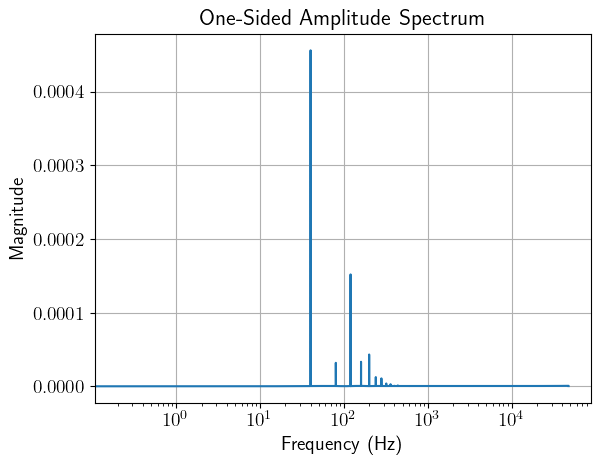

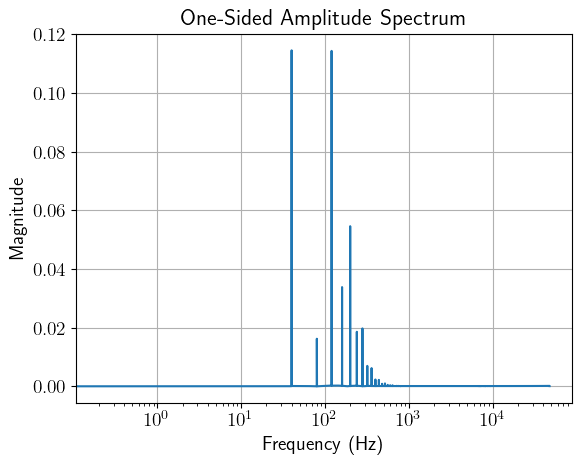

THD 0.7628456209849626


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import engutil 
import util

duration = 5.0
fs = 96000
#t_eval = np.linspace(0, duration, int(fs*duration))
#u = util.generate_pink_noise(len(t_eval), fs, fmin=1)


data_loaded = pd.read_csv("data/part2d_simulations/01_nonlinear_full_5sec_at_96000.0.csv")

#nonlinear_full = pd.read_csv("data/part2_simulations/02_nonlinear_stiffness_only.csv")

t_1 = data[0]
u_1 = data[1]
i_1 = data[2]
d_1 = data[3]
v_1 = data[4]
X_1 = np.array([i,d,v])

u_2 = data_loaded["u"]
v_2 = data_loaded["vel"]

print(f"THD {val_thd}")

# G_iu, G_du, G_vu, f = util.welchie(u, X, fs)
# G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
# G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
# G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)


# engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="dB re 1 m/V")
# engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="dB re 1 S")
# engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="dB re 1 (m/s)/V")